#  Imports and functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random

from sklearn.linear_model import Lasso, LinearRegression as LR
from sklearn.linear_model import Ridge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import StandardScaler as SS

from sklearn.model_selection import train_test_split as tts

from IPython.display import clear_output
from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import kstest

from scipy.stats import wasserstein_distance


In [ ]:

def GetColors(N, cmap_name='rainbow'):
    from matplotlib.cm import get_cmap
    import numpy as np

    cmap = get_cmap(name=cmap_name)
    n = np.linspace(0,1,N)
    return cmap(n)

def PlotGroups(points, groups, colors):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,6))

    for i, yi in enumerate(np.unique(groups)):
        idx = (groups == yi)
        plt.scatter(points[idx, 0], points[idx, 1],
                    alpha=0.5, ec='k', color=colors[i], label = yi)
    plt.axis('equal')
    plt.legend(loc='center left', bbox_to_anchor=[1, 0.5])
    #plt.show()
    return

def CompareClasses(actual, predicted, names=None):
    classes = pd.DataFrame(columns=['Predicted','Actual'])
    classes['Predicted'] = predicted
    classes['Actual'] = actual

    conf_mat = pd.crosstab(columns=classes['Predicted'],
                       index = classes['Actual'])
    if names != None:
        conf_mat.columns = names
        conf_mat.index = names

    conf_mat.columns.name = 'Predicted'
    conf_mat.index.name = 'Actual'

    accuracy = sum(predicted==actual)/len(actual)

    return conf_mat, accuracy

def DoKFold(model, X, y, k, scaler=None):
    from sklearn.model_selection import KFold
    import pandas as pd

    kf = KFold(n_splits=k, shuffle=True)

    if type(X) == pd.core.frame.DataFrame:
        X = X.values

    training_scores=[]
    testing_scores=[]

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain,:]
        Xtest = X[idxTest,:]
        ytrain = y[idxTrain]
        ytest = y[idxTest]

        if scaler != None:
            # For standardization:
            # Fit/transform on training data
            Xtrain = scaler.fit_transform(Xtrain)
            #
            # Only transform (i.e, don't refit) on test data
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        training_scores.append(model.score(Xtrain,ytrain))
        testing_scores.append(model.score(Xtest,ytest))

    return training_scores, testing_scores

def plot_train_test(train, test, width, x_lab = None, y_lab = 'Mean Accuracy'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    plt.plot(width, train, '-kx')
    plt.plot(width, test, '-rx')
    plt.legend()
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()


# Model simulation code


In [1]:
from math import sqrt
from array import *
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime as dt
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Colab Notebooks
%run run_model.ipynb
run_model(x_input,t_final)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


342.2243670511788

# Data simulator function

In [ ]:
def simulate_data_set(prop_var = 0.1, N = 5, dims_to_use = []):
    overall_start = dt.now()
    import numpy as np
    import random
    from IPython.display import clear_output

    sim_input = []
    #Baseline values for each variable as a dict

    baseline = {'t_final': [60, 60*prop_var],  # [sec]
                    'h_tile': [.0254, .0254*prop_var],    # [m]
                    'h_Ti': [0.00015, 0.00015*prop_var],    # [m]
                    'rho_tile': [144, 144*prop_var],   # [kg/m^3]
                    'rho_Ti': [4540, 4540*prop_var],  # [kg/m^3]
                    'cp_tile': [628, 628*prop_var],   # [J/kg*K]
                    'cp_Ti': [460, 460*prop_var],   # [J/kg*K]
                    'k_tile': [0.126, 0.126*prop_var], # [W/mK]
                    'k_Ti': [7.1, 7.1*prop_var],   # [W/mK]
                    'emissivity': [0.8, 0.8*prop_var],
                    'M_inf': [5.0, 5.0*prop_var],     # Freestream Mach number
                    'p_inf': [2736.0, 2736.0*prop_var],  # Freestream pressure [Pa]
                    'T_inf': [284.0, 284*prop_var],   # Freestream temperature [K]
                    'fudge_factor': [1.0, 1.0*prop_var]
                    }

    sim_data = pd.DataFrame()

    for k,v in baseline.items():
      column = []
      for n in range(N):
        if k in dims_to_use or dims_to_use == []:
          column.append(random.gauss(v[0], v[1]))
        else:
          column.append(v[0])
      sim_data[k] = column

    print('values calculated, moving to simulations')

    simulator_values = []
    for i in range(len(sim_data)):
      clear_output()
      print('values calculated, moving to simulations')
      print('simulator iteration', i)
      print('Runtime:', dt.now()-overall_start)
      values = sim_data.loc[i]
      #print(values)
      #print(run_model(values[1:], values[0]))
      simulator_values.append(run_model(values[1:],values[0]))

    sim_data['Final_temp'] = simulator_values

    #clear_output()
    print('Runtime:', dt.now()-overall_start)


    return(sim_data)





### Testing on only t_final

In [ ]:
#MC_simulated_data = simulate_data_set(N = 1000, dims_to_use = ['t_final'])
lasso_training_set = simulate_data_set(N = 450, dims_to_use = ['t_final'])
lasso_validation_set = simulate_data_set(N = 550, dims_to_use = ['t_final'])

values calculated, moving to simulations
simulator iteration 549
Runtime: 0:08:22.848195
Runtime: 0:08:23.703760


In [ ]:
gpr_training_set = simulate_data_set(N = 450, dims_to_use = ['h_tile'])
gpr_validation_set = simulate_data_set(N = 550, dims_to_use = ['h_tile'])

values calculated, moving to simulations
simulator iteration 549
Runtime: 0:08:17.728527
Runtime: 0:08:18.507668


In [ ]:
dimensions = lasso_training_set.drop('Final_temp', axis = 1)
target = lasso_training_set['Final_temp']

ss = SS()

dimensions_st = ss.fit_transform(dimensions)

In [ ]:
dimensions = gpr_training_set.drop('Final_temp', axis = 1)
target = gpr_training_set['Final_temp']

ss = SS()

dimensions_st = ss.fit_transform(dimensions)

In [ ]:
training_scores = []
testing_scores = []
k = 100
a_range = np.linspace(0.01, 0.5, 100)

for a in a_range:
    clear_output()
    print('Currently testing alpha =', a)
    las = Lasso(alpha=a)
    tr,te = DoKFold(las,dimensions_st, target,k)

    training_scores.append(tr)
    testing_scores.append(te)

mean_tr = []
mean_te = []
for score_set in training_scores:
    mean_tr.append(np.mean(score_set))
for te_set in testing_scores:
    mean_te.append(np.mean(te_set))



Currently testing alpha = 0.5


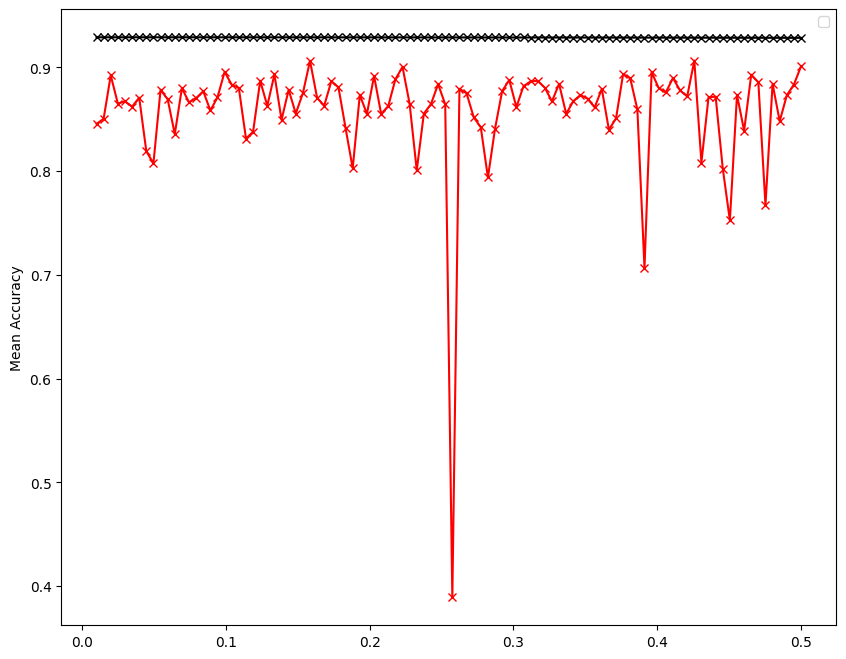

In [ ]:
plot_train_test(mean_tr, mean_te, a_range)

In [ ]:
best_alpha = a_range[np.argmax(mean_te)]
tuned_las = Lasso(alpha = best_alpha)
best_alpha

0.4257575757575757

In [ ]:
tuned_las.fit(dimensions_st, target)
tuned_las.score(dimensions_st, target)

0.9285828315427196

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

constant = 1

kernel = constant * RBF(length_scale= 1.0, length_scale_bounds=(1e-3, 1e3))

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)

gpr.fit(dimensions_st, target)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9, normalize_y=True)

In [ ]:
def use_surrogate_model(model, volume, dims_to_use = [], prop_var = 0.1):
  overall_start = dt.now()
  import random
  from sklearn.preprocessing import StandardScaler as SS
  from IPython.display import clear_output

  sim_input = []
  #Baseline values for each variable as a dict

  baseline = {'t_final': [60, 60*prop_var],  # [sec]
                  'h_tile': [.0254, .0254*prop_var],    # [m]
                  'h_Ti': [0.00015, 0.00015*prop_var],    # [m]
                  'rho_tile': [144, 144*prop_var],   # [kg/m^3]
                  'rho_Ti': [4540, 4540*prop_var],  # [kg/m^3]
                  'cp_tile': [628, 628*prop_var],   # [J/kg*K]
                  'cp_Ti': [460, 460*prop_var],   # [J/kg*K]
                  'k_tile': [0.126, 0.126*prop_var], # [W/mK]
                  'k_Ti': [7.1, 7.1*prop_var],   # [W/mK]
                  'emissivity': [0.8, 0.8*prop_var],
                  'M_inf': [5.0, 5.0*prop_var],     # Freestream Mach number
                  'p_inf': [2736.0, 2736.0*prop_var],  # Freestream pressure [Pa]
                  'T_inf': [284.0, 284*prop_var],   # Freestream temperature [K]
                  'fudge_factor': [1.0, 1.0*prop_var]
                  }

  sim_data = pd.DataFrame()

  for k,v in baseline.items():
    column = []
    for n in range(volume):
      if k in dims_to_use:
        column.append(random.gauss(v[0], v[1]))
      else:
        column.append(v[0])
    sim_data[k] = column

  print('values calculated, moving to simulations')

  ss = SS()
  st_data = ss.fit_transform(sim_data)

  preds = model.predict(st_data)

  sim_data['Final_temp'] = preds

  print('Simulation complete')


  return(sim_data)

In [ ]:
new_data = use_surrogate_model(model = gpr, volume = 550, dims_to_use = ['h_tile'])

values calculated, moving to simulations
Simulation complete


In [ ]:
new_data

,t_final,h_tile,h_Ti,rho_tile,rho_Ti,cp_tile,cp_Ti,k_tile,k_Ti,emissivity,M_inf,p_inf,T_inf,fudge_factor,Final_temp
0,60,0.031858,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,311.773403
1,60,0.025441,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,342.471946
2,60,0.023052,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,365.132244
3,60,0.023287,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,362.521825
4,60,0.028073,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,325.696056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,60,0.030179,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,316.787099
546,60,0.027937,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,326.395343
547,60,0.025123,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,345.030308
548,60,0.027297,0.00015,144,4540,628,460,0.126,7.1,0.8,5.0,2736.0,284.0,1.0,329.901007


In [ ]:
#lasso_training_set = lasso_training_set.rename(columns = {'simulator_values': 'Final_temp'})
#new_data = new_data.rename(columns = {'Model_predictions': 'Final_temp'})

In [ ]:
Validation_dims = lasso_validation_set.drop('Final_temp', axis = 1)
validation_target = lasso_validation_set['Final_temp']

ss = SS()

Validation_dims_st = ss.fit_transform(Validation_dims)


In [ ]:
Validation_dims = gpr_validation_set.drop('Final_temp', axis = 1)
validation_target = gpr_validation_set['Final_temp']

ss = SS()

Validation_dims_st = ss.fit_transform(Validation_dims)


In [ ]:
validation_preds = tuned_las.predict(Validation_dims_st)


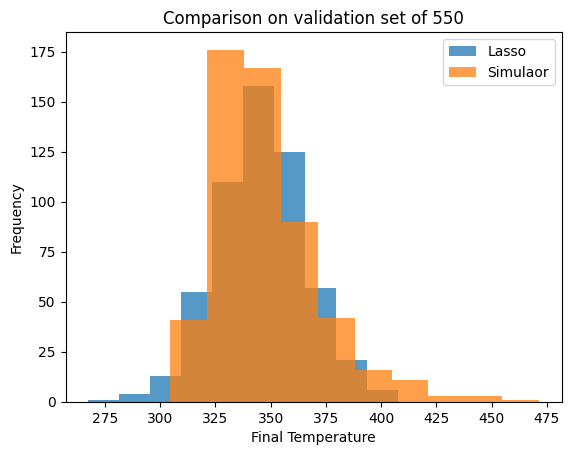

In [ ]:
plt.hist(validation_preds, alpha = 0.75)
plt.hist(validation_target, alpha = 0.75)

plt.xlabel('Final Temperature')
plt.ylabel('Frequency')


plt.title('Comparison on validation set of 550')
#plt.figtext('Distributions of final temperatures from a validation set of 550 and the predicted values of those 550 temperatures')

plt.legend(['Lasso', 'Simulaor'])

In [ ]:
ks_2samp(validation_preds, validation_target)

KstestResult(statistic=0.06727272727272728, pvalue=0.16594191052452847, statistic_location=342.7923442305104, statistic_sign=-1)

In [ ]:
wasserstein_distance(validation_preds, validation_target)

4.225033837061326

### Testing on all dimensions

In [ ]:
tr = simulate_data_set(N = 450, dims_to_use = [])
te = simulate_data_set(N = 550, dims_to_use = [])

values calculated, moving to simulations
simulator iteration 549
Runtime: 0:08:05.553979
Runtime: 0:08:06.331764


(array([149., 194., 119.,  47.,  23.,   9.,   4.,   3.,   1.,   1.]),
 array([302.03397614, 325.70340159, 349.37282703, 373.04225248,
        396.71167792, 420.38110336, 444.05052881, 467.71995425,
        491.3893797 , 515.05880514, 538.72823059]),
 <BarContainer object of 10 artists>)

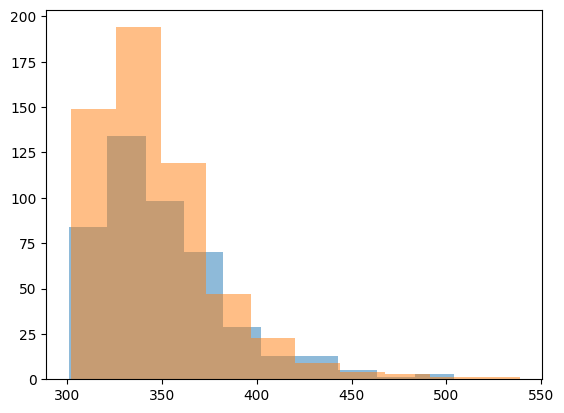

In [ ]:
plt.hist(tr['Final_temp'], alpha = 0.5)
plt.hist(te['Final_temp'], alpha = 0.5)

In [ ]:
tr_X = tr.drop('Final_temp', axis = 1)
tr_y = tr['Final_temp']

ss_tr = SS()
tr_X_st = ss_tr.fit_transform(tr_X)


te_X = te.drop('Final_temp', axis = 1)
te_y = te['Final_temp']

ss_te = SS()
te_X_st = ss_tr.fit_transform(te_X)

In [ ]:
training_scores = []
testing_scores = []
k = 100
a_range = np.linspace(0.01, 0.5, 100)

for a in a_range:
    clear_output()
    print('Currently testing alpha =', a)
    las = Lasso(alpha=a)
    tr,te = DoKFold(las,tr_X_st, tr_y,k)

    training_scores.append(tr)
    testing_scores.append(te)

mean_tr = []
mean_te = []
for score_set in training_scores:
    mean_tr.append(np.mean(score_set))
for te_set in testing_scores:
    mean_te.append(np.mean(te_set))



Currently testing alpha = 0.5


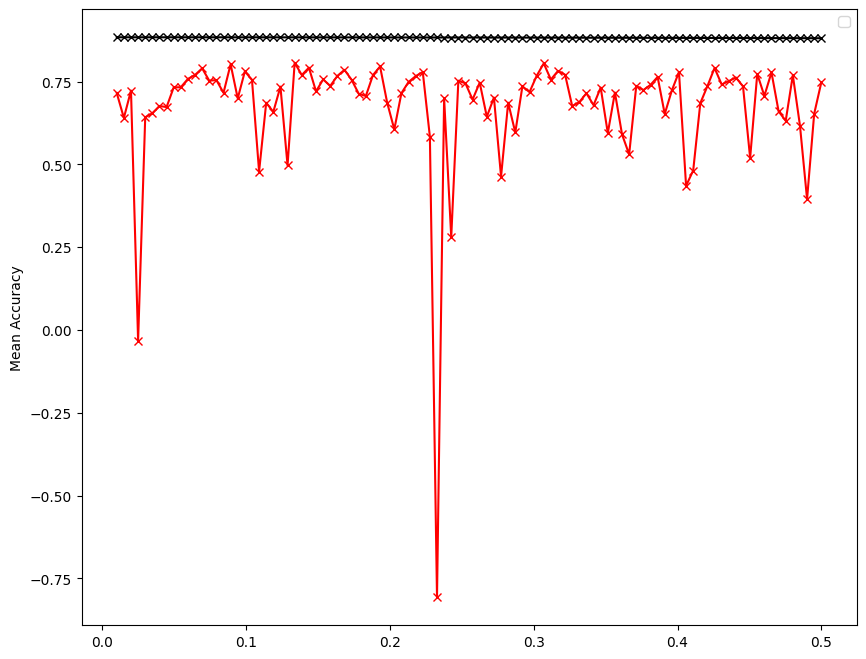

In [ ]:
plot_train_test(mean_tr, mean_te, a_range)

In [ ]:
best_alpha = a_range[np.argmax(mean_te)]
tuned_las = Lasso(alpha = best_alpha)
best_alpha

0.13373737373737374

In [ ]:
tuned_las.fit(tr_X_st, tr_y)
tuned_las.score(tr_X_st, tr_y)

0.8836466388017874

In [ ]:
val_preds = tuned_las.predict(te_X_st)

In [ ]:
print(mean_squared_error(te_y, val_preds))
print(mean_absolute_error(te_y, val_preds))
print(r2_score(te_y, val_preds))


127.56953596959045
8.52343037430357
0.8763012403489641


In [ ]:
print(np.mean(val_preds) - np.mean(te_y))
print(np.std(val_preds) - np.std(te_y))

1.9923323685175092
-1.8157362001688284


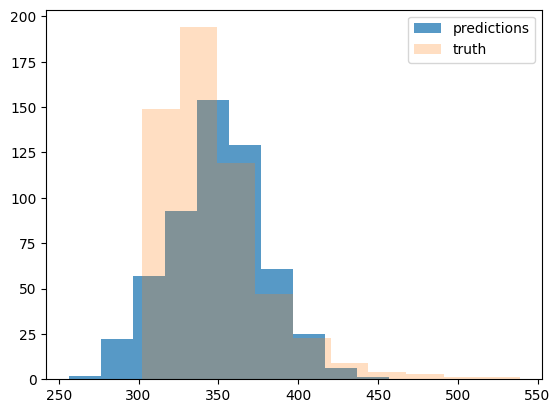

In [ ]:
plt.hist(val_preds, alpha = 0.75)
plt.hist(te_y, alpha = 0.25)
plt.legend(['predictions', 'truth'])

#### This is not great, MSE is much higher than expected
- Assumption: This is due to lack of normality in target temp
  - Solution: Box cox or maybe gamma regression

In [ ]:
bc_tr_y, bc_lambda = stats.boxcox(tr_y)

-4.504968194727382


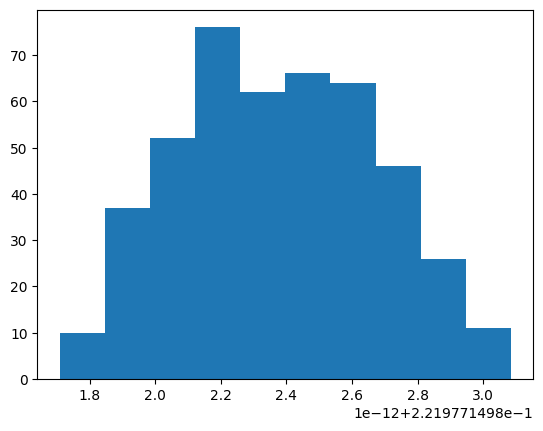

In [ ]:
print(bc_lambda)
plt.hist(bc_tr_y)
plt.show()

In [ ]:
training_scores = []
testing_scores = []
k = 100
a_range = np.linspace(0.01, 0.5, 100)

for a in a_range:
    clear_output()
    print('Currently testing alpha =', a)
    las = Lasso(alpha=a)
    tr,te = DoKFold(las,tr_X_st, bc_tr_y,k)

    training_scores.append(tr)
    testing_scores.append(te)

mean_tr = []
mean_te = []
for score_set in training_scores:
    mean_tr.append(np.mean(score_set))
for te_set in testing_scores:
    mean_te.append(np.mean(te_set))



Currently testing alpha = 0.5


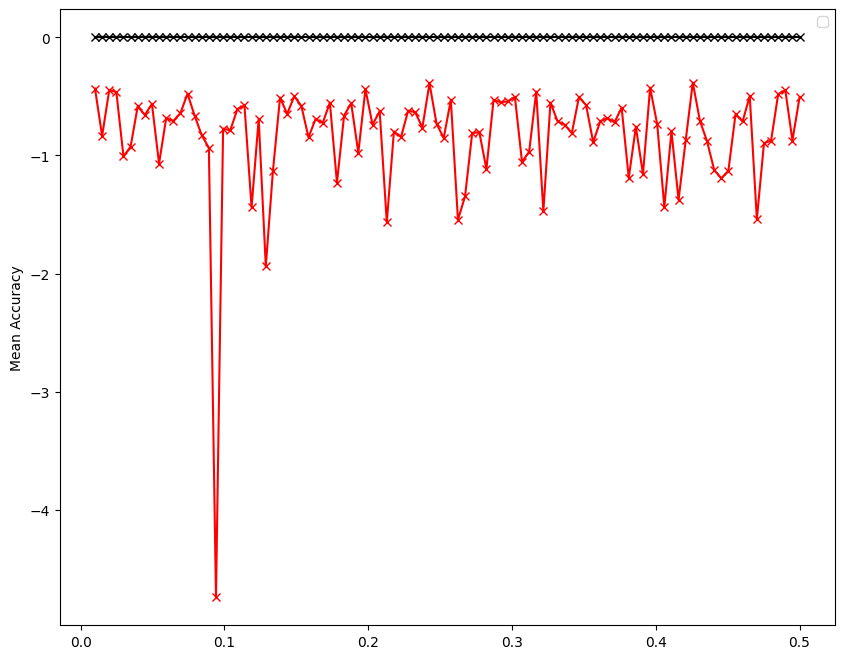

In [ ]:
plot_train_test(mean_tr, mean_te, a_range)